In [2]:
import csv
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.backend import tf #as ktf
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from sklearn.utils import shuffle
import math
import random as rand
import pandas as pd

Using TensorFlow backend.


## Get data
For this project, I initally try to ran the simulator. However I'm not very satisfied with my own driving. After some research, I saw other classmates mentioned the driving quality has a high impact. So I decide to start with Udacity's driving data.   

Although I didn't use my own driving, I think a few things is worth to notice when generating the driving data: 
1. Drive nicely, stay in the center of the road.... most of the time
2. Intentionaly drive towards the side(turn off recording when you are doing this). And **recovery** to center. 

In [13]:
UDACITY_DATA_PATH = '/home/carnd/P3/data1_udacity/data_udacity/'            
lines = []
with open(UDACITY_DATA_PATH+'driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
            #if abs(float(line[3]))>=0:
        line = [i.replace('IMG','/home/carnd/P3/data1_udacity/data_udacity/IMG') for i in line]
        lines.append(line)
        
print(len(lines))

8036


One problem deep learning couldn't avoid is overfitting. To reduce this problem, we were often recommended to get lots lots of data. So that the training set covers all the possible scenarios. If getting real data is not possible, then we could artificially add random shadow, cut images to generate endless new images to feed the network. So even myself, initially, I spent tremendous time on data augumentation.  

But before that, I missed a cruicial step. [Alex's post](http://navoshta.com/end-to-end-deep-learning/) really gave me a huge hint. 

## Balance data

Udacity provide 8k records, which is not too small. If I look into these 8000 images, then I can easily find the majority of images have very small steering angel. If I don't do anything just dump the data as it is, the model could simply predict every image steer 0 still get good result.  
With that being said, I applied a designated random sampling which ensured that the data is as balanced across steering angles as possible. This process included splitting steering angles into 100 bins and using at most 300 frames for each bin

In [3]:
column_names = ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']
df = pd.DataFrame(lines,columns=column_names)
df[0:5]

,center,left,right,steering,throttle,brake,speed
0,/home/carnd/P3/data1_udacity/data_udacity/IMG/...,/home/carnd/P3/data1_udacity/data_udacity/IMG...,/home/carnd/P3/data1_udacity/data_udacity/IMG...,0,0,0,22.14829
1,/home/carnd/P3/data1_udacity/data_udacity/IMG/...,/home/carnd/P3/data1_udacity/data_udacity/IMG...,/home/carnd/P3/data1_udacity/data_udacity/IMG...,0,0,0,21.87963
2,/home/carnd/P3/data1_udacity/data_udacity/IMG/...,/home/carnd/P3/data1_udacity/data_udacity/IMG...,/home/carnd/P3/data1_udacity/data_udacity/IMG...,0,0,0,1.453011
3,/home/carnd/P3/data1_udacity/data_udacity/IMG/...,/home/carnd/P3/data1_udacity/data_udacity/IMG...,/home/carnd/P3/data1_udacity/data_udacity/IMG...,0,0,0,1.438419
4,/home/carnd/P3/data1_udacity/data_udacity/IMG/...,/home/carnd/P3/data1_udacity/data_udacity/IMG...,/home/carnd/P3/data1_udacity/data_udacity/IMG...,0,0,0,1.418236


Number of records: 8036


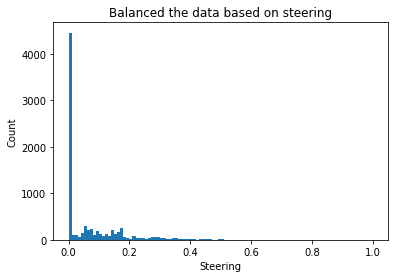

In [4]:
print("Number of records:",df.shape[0])
plt.hist(abs(pd.to_numeric(df["steering"])),100)
plt.xlabel('Steering')
plt.ylabel('Count')
plt.title("Balanced the data based on steering")
#plt.ylim(0,5000)
#plt.grid(True)

plt.show()

In [10]:
balanced = pd.DataFrame()   # Balanced dataset
bins = 100                 # N of bins
bin_n = 300                 # N of examples to include in each bin (at most)

start = 0
for end in np.linspace(0, 1, num=bins):  
    df_range = df[(np.absolute(pd.to_numeric(df.steering)) > start) & (np.absolute(pd.to_numeric(df.steering)) <= end)]
    range_n = min(bin_n, df_range.shape[0])
    if df_range.shape[0]>0:
        balanced = pd.concat([balanced, df_range.sample(range_n)])
    start = end
#balanced.to_csv('driving_log_balanced.csv', index=False, header=False)
balanced[0:5]


,center,left,right,steering,throttle,brake,speed
7384,/home/carnd/P3/data1_udacity/data_udacity/IMG/...,/home/carnd/P3/data1_udacity/data_udacity/IMG...,/home/carnd/P3/data1_udacity/data_udacity/IMG...,-0.002791043,0.9855326,0,30.18664
7397,/home/carnd/P3/data1_udacity/data_udacity/IMG/...,/home/carnd/P3/data1_udacity/data_udacity/IMG...,/home/carnd/P3/data1_udacity/data_udacity/IMG...,-0.002791043,0.9855326,0,30.18662
7400,/home/carnd/P3/data1_udacity/data_udacity/IMG/...,/home/carnd/P3/data1_udacity/data_udacity/IMG...,/home/carnd/P3/data1_udacity/data_udacity/IMG...,-0.002791043,0.9855326,0,30.18664
7431,/home/carnd/P3/data1_udacity/data_udacity/IMG/...,/home/carnd/P3/data1_udacity/data_udacity/IMG...,/home/carnd/P3/data1_udacity/data_udacity/IMG...,-0.002791043,0.9855326,0,30.18663
2134,/home/carnd/P3/data1_udacity/data_udacity/IMG/...,/home/carnd/P3/data1_udacity/data_udacity/IMG...,/home/carnd/P3/data1_udacity/data_udacity/IMG...,-0.002791043,0.9855326,0,30.18664


Number of records kept for data augument: 3675


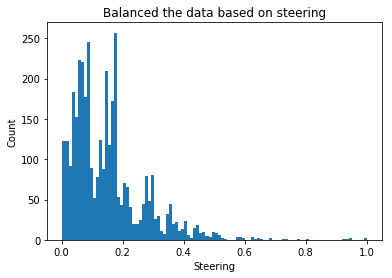

In [12]:
print("Number of records kept for data augument:",balanced.shape[0])
plt.hist(abs(pd.to_numeric(balanced["steering"])),100)
plt.xlabel('Steering')
plt.ylabel('Count')
plt.title("Balanced the data based on steering")
plt.show()

In [3]:
balance = []
with open('driving_log_balanced.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        balance.append(line)    

## Look at the data/data preprocess
The simulator provides 3 camera, front, left, center.  

Also we can see this image has a lot of sky, and car hood. These pixels are noise, not provide useful information, also will increase the computation speed. So I cropped the image to keep only the road part. For visualization purpose, here I just use pixel index to select the area I want.  
Later when I intergrate data process and training into a keras model. I will use 2DCropping function in Keras.

Looking at Image Number:1118, Steering angel:-0.0693


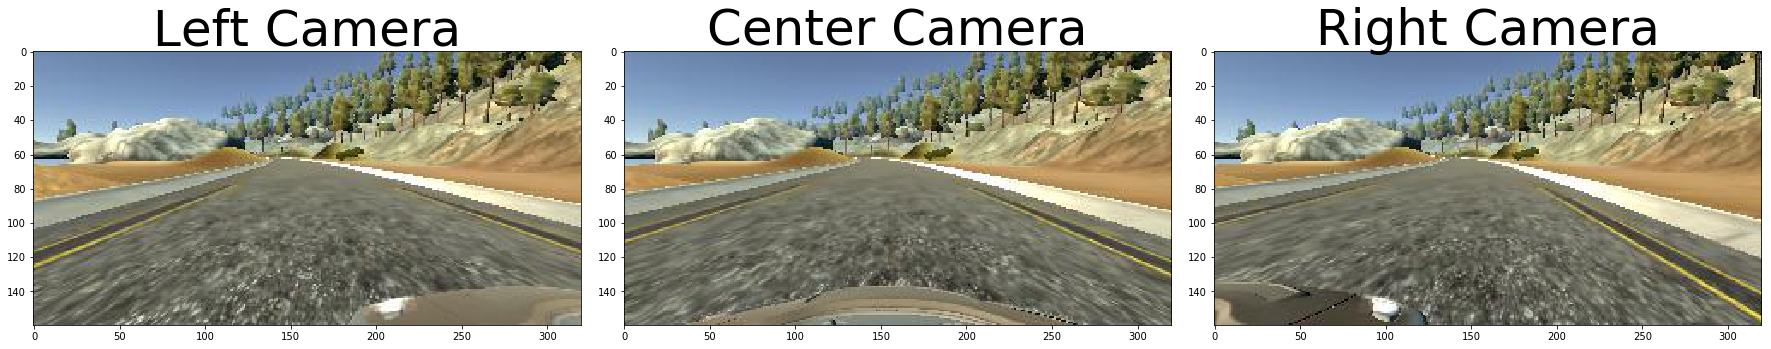

In [4]:
i = np.random.randint(len(balance))
left_img = mpimg.imread(balance[i][1].lstrip())
left_img = left_img
center_img = mpimg.imread(balance[i][0].lstrip())
right_img = mpimg.imread(balance[i][2].lstrip())
print('Looking at Image Number:{:2d}, Steering angel:{:.4f}'.format(i,float(balance[i][3])))

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(left_img)
ax1.set_title('Left Camera', fontsize=50)
ax2.imshow(center_img)
ax2.set_title('Center Camera', fontsize=50)
ax3.imshow(right_img)
ax3.set_title('Right Camera', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=2, bottom=0.)

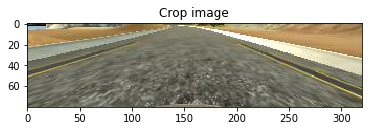

In [5]:
plt.imshow(center_img[60:140,])
plt.title("Crop image")

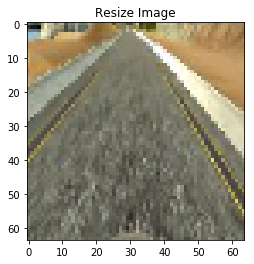

In [6]:
resize_img = cv2.resize(center_img[60:140,],(64,64))
plt.imshow(resize_img)
plt.title("Resize Image")

## Data augumentation
For training data, I want to create as many different images as possible:  
* Left and right cameras. Use left and right cameras data during training after applying steering angle correction
* Horizontal flip. For every batch we flip half of the frames horizontally and change the sign of the steering angle  
  
For validation data, I don't want to change the image, do any preprocess.

In [7]:
side = True
flip = True
def preprocess_image_file_train(line_data):
    # Use side camera, random select from left, center and right
    if side:
        i_lrc = np.random.randint(3)
        if (i_lrc == 0):
            path_file = line_data[0]
            shift_ang = 0
        if (i_lrc == 1):
            path_file = line_data[1].lstrip()
            shift_ang = 0.25
        if (i_lrc == 2):
            path_file = line_data[2].lstrip()
            shift_ang = -.25
        y_steer = float(line_data[3]) + shift_ang
    else:
        path_file = line_data[0]
    
    image = mpimg.imread(path_file.lstrip())
    image = np.array(image)
#     image = cv2.cvtColor(image,cv2.COLOR_RGB2LUV)
    
    # Use flip image, random select use original or filp image
    if flip:
        ind_flip = np.random.randint(2)
        if ind_flip==0:
            image = cv2.flip(image,1)
            y_steer = -y_steer
        
    return image,y_steer

In [8]:
def preprocess_image_file_val(line_data):
    path_file = line_data[0]
    y_steer = float(line_data[3])
    image = mpimg.imread(path_file.lstrip())
    image = np.array(image)
    return image,y_steer

Y steer: -0.31925154


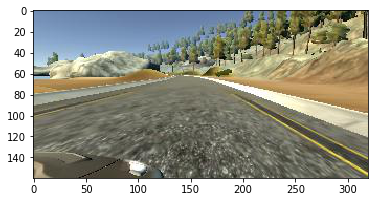

In [9]:
image,y_steer = preprocess_image_file_train(balance[i])
image.shape
plt.imshow(image)
# print(lines[10])
print("Y steer:", y_steer)

# Generator

Generator is a new concept I learnt from this project. When working on large dataset, like images. Sometimes simply loading images  will exceed the size of memory. Generator allows to process a subset of data once a time, and keep track of last position.  
For training set, the generator use preprocess funtion for training set. For validation set, generator use preprocess function for validation set

In [10]:
def generate_train_from_PD_batch(data,batch_size = 32):
    while 1:
        batch_images=[]
        batch_steering = []
        for i_batch in range(batch_size):
            i_line = np.random.randint(len(data))
            line_data = data[i_line]#.reset_index()
            x,y = preprocess_image_file_train(line_data)
            batch_images.append(x)
            batch_steering.append(y)
        yield np.array(batch_images), np.array(batch_steering)

In [11]:
def generate_val_from_PD_batch(data,batch_size = 32):    
    n = len(data)
    while 1:
        for offset in range(0,n, batch_size):
            batch_images=[]
            batch_steering = []
            batch = data[offset:offset+batch_size]
            for line in batch:
                x,y = preprocess_image_file_val(line)
                batch_images.append(x)
                batch_steering.append(y)
            yield shuffle(np.array(batch_images), np.array(batch_steering))

The steering measurements are angles, are not radians.
They are normalized to be in range -1 and 1, corresponding in the car to -25 to 25 degrees.

## Training and validation split
Initially I used train_test_split in `sklearn`, I splited from balanced dataset, 80% used for training, 20% for validation. Later I realized for validation, using the original full track's performance makes more sense:  
1. All the nice images from balance data set could be used in trainig model  
2. Using same validation data, without randomness, makes the model performance comparable not only within epoches, but also across mutliple models  

Technically, validation set image shouldn't be seen in the training, so people may have a different opinion regarding my approach. For me it works nicely, so I just keep it this way. 

In [14]:
# from sklearn.model_selection import train_test_split
# # from sklearn.cross_validation import train_test_split
# lines, lines_val = train_test_split(lines, test_size=0.2)
# print("Training lines:{:02d}; Validation lines:{:02d}".format(len(lines),len(lines_val)))

In [14]:
train_generator = generate_train_from_PD_batch(balance, batch_size=32)
validation_generator = generate_train_from_PD_batch(lines, batch_size=32)

# Modeling

## Architecture 
Surprisingly, in the end I used a quite simple model to solve the problem.  

Conv 16 - 3×3  
Pooling 2×2  
Conv 32 - 3×3  
Pooling 2×2  
Conv 64 - 3×3  
Pooling 2×2  
  
Flatten  
  
Fully connect 500  
Dropout 0.2  
Fully connect 100  
Dropout 0.2  
Fully connect 20  
Fully connect 1  

I use 2 dropout layers to avoid overfitting. 

In [15]:
model = Sequential()
def myLambda(x):
    from keras.backend import tf as ktf
    return ktf.image.resize_images(x, (64,64))
    

#Theano use differnet format (samples, channels, rows, cols)
model.add(Cropping2D(cropping=((60,20),(0,0)),input_shape = (160, 320, 3)))
model.add(Lambda(myLambda))
model.add(Lambda(lambda x: x/255-0.5))#,input_shape = (64, 64, 3)))

model.add(Convolution2D(16, 3, 3, input_shape=(32, 128, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(20, activation='relu'))
model.add(Dense(1))

The model was trained using Adam optimiser and mean squared error as a loss function.  I ran 20 epoches, each epoched I use 3838 images for training, total 8034 for validation. Note that the training set is random, so they are not the same images for every ephoch. The validation data is the same. Thus the validation loss is comparable between epochs and different models.  

Sometimes the model will overfit if I use too many epoches. Maybe in the middle, an epoch is the best. By looking at the validation loss, I can have a feel how the model improve/overfit over time.  
In order to retrive the training weights for each epoch, I add a call back list. To store the weights, I only curious to see the weights when validation loss is decrease. But Keras has the capability to store all the weights.  

In [18]:
model.compile(loss='mse',optimizer='adam')

t0=time.time()
filepath="Test-{epoch:02d}-val_loss:{val_loss:.4f}-423.h5" # If save each improve sepearte
# filepath="best_model.h5" # Only save the best model, by save all the improvements overwirte into same file  
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True,mode='min')
callbacks_list = [checkpoint]

model.fit_generator(train_generator, samples_per_epoch= len(balance)
                    , validation_data= validation_generator,
                    nb_val_samples= len(lines)
                    ,callbacks= callbacks_list
                    , nb_epoch=20)
t1=time.time()

print("Training completed in " + str(round((t1-t0)/60,2)) + " minutes")
# Steering -0.2, validation loss = 0.0302
# Steering 0.2, validation loss = 0.0239
# Steering 0.3, validation loss = 0.0254
# Steering 0.25, validation loss = 0.0244
# Steering 0.15 0.023

Epoch 1/20
3808/3838 [============================>.] - ETA: 0s - loss: 0.0360  

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 00000: val_loss improved from inf to 0.02551, saving model to Test-00-val_loss:0.0255-423.h5
3840/3838 [==============================] - 31s - loss: 0.0359 - val_loss: 0.0255
Epoch 2/20
3840/3838 [==============================] - 25s - loss: 0.0297 - val_loss: 0.0222
Epoch 3/20
3840/3838 [==============================] - 23s - loss: 0.0272 - val_loss: 0.0246
Epoch 4/20
3840/3838 [==============================] - 22s - loss: 0.0261 - val_loss: 0.0204
Epoch 5/20
3840/3838 [==============================] - 22s - loss: 0.0242 - val_loss: 0.0219
Epoch 6/20
3840/3838 [==============================] - 21s - loss: 0.0245 - val_loss: 0.0232
Epoch 7/20
3840/3838 [==============================] - 21s - loss: 0.0235 - val_loss: 0.0225
Epoch 8/20
3840/3838 [==============================] - 21s - loss: 0.0229 - val_loss: 0.0238
Epoch 9/20
3840/3838 [==============================] - 21s - loss: 0.0239 - val_loss: 0.0211
Epoch 10/20
3840/3838 [==============================] - 21s - los

In [19]:
model.save('/home/carnd/P3/model.h5')

## Additional information:
This project too me a long time, so I read many other people's post/question, some useful links:
1. [Dynamic adjust steering angel for side cameras](https://hoganengineering.wixsite.com/randomforest/single-post/2017/03/13/Alright-Squares-Lets-Talk-Triangles)
2. [More augumentation techniques](https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9)
3. [Generator](https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/)
4. [Nvidia model](http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf)

## Improvements:  

1. If I increase the speed in drive.py to 20, the car is shift left and right, although it's still driving on the track, it's very like drunk drive. So I'm curious to see it perform on a better hardware.  
2. Add multiple random augumentation like shadow, light etc...  
3. Since I already finished P4 and P5 before this one, I learnt more techniques like color space transformation. this makes me wonder if I transfer the color to HSL, can I use "hue" only to train the model. And will it robust towards different shadow/light  